## Run AA operational monitoring script

#### (can be used for a more user-friendly experience or for training purposes)

#### (note: having run entirely the `run_full_verification` notebook is a prerequisite to run this one)

This notebook reads a forecasts dataset (corresponding to a specific issue month) and computes the corresponding probabilities. These probabilities are merged with the pre-computed triggers dataframe to be displayed on the dashboard.

**Import required libraries and functions**

In [1]:
import os

import pandas as pd
from hip.analysis.analyses.drought import get_accumulation_periods
from hip.analysis.aoi.analysis_area import AnalysisArea

from AA.helper_fns import read_forecasts, read_observations, read_triggers
from AA.operational import run_full_index_pipeline
from config.params import Params

if os.getcwd().split("\\")[-1] != "anticipatory-action":
    os.chdir("..")
os.getcwd()

C:\Users\amine.barkaoui\OneDrive - World Food Programme\Documents\GitHub\anticipatory-action\.pixi\envs\default\lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


'C:\\Users\\amine.barkaoui\\OneDrive - World Food Programme\\Documents\\GitHub\\anticipatory-action'

**First, please define the country ISO code, the issue month and the index of interest**

In [ ]:
country = "ISO" # Replace with the ISO code of the country you want to run the monitoring for
issue = 10
index = "SPI"  # 'SPI' or 'DRYSPELL'
data_path = "."  # anticipatory-action directory
output_path = "."

Now, we will configure some parameters. Please feel free to edit the `{country}_config.yaml` file if you need to change the *monitoring_year* or any other relevant parameter.

In [64]:
params = Params(
    iso=country,
    issue=issue,
    index=index,
    data_path=data_path,
    output_path=output_path,
)

### Read data

Let's start by getting the shapefile.

In [55]:
area = AnalysisArea.from_admin_boundaries(
    iso3=params.iso.upper(),
    admin_level=2,
    resolution=0.25,
    datetime_range=f"1981-01-01/{params.monitoring_year + 1}-06-30",
)

gdf = area.get_dataset([area.BASE_AREA_DATASET])
gdf

,geometry,Code,Name,adm1_Code,adm0_Code
Name,,,,,
Kapiri Mposhi,"POLYGON ((29.13 -13.9415, 29.1047 -13.8826, 29...",1009321,Kapiri Mposhi,900844,270
Serenje,"POLYGON ((31.052 -13.7573, 31.0045 -13.6686, 3...",1009326,Serenje,900844,270
Chisamba,"POLYGON ((29.007 -14.9915, 29.0021 -14.905, 28...",1009309,Chisamba,900844,270
Mkushi,"POLYGON ((30.0982 -13.9316, 30.0724 -13.8555, ...",1009334,Mkushi,900844,270
Itezhi-tezhi,"POLYGON ((27.2792 -15.7202, 27.2028 -15.4684, ...",1009246,Itezhi-tezhi,900844,270
...,...,...,...,...,...
Chinsali,"POLYGON ((32.5871 -10.4406, 32.5254 -10.4231, ...",1009307,Chinsali,900849,270
Chama,"POLYGON ((32.3454 -12.0543, 32.3714 -12.0913, ...",1009285,Chama,900849,270
Shiwamg'andu,"POLYGON ((32.3855 -10.8334, 32.2613 -10.8466, ...",1009288,Shiwamg'andu,900849,270


The next cell reads the observations dataset. Please run it directly if you have the data stored in the specified path or have access to HDC.


*Note:*

If you previously ran the `run-full-verification` notebook, you probably already have the dataset stored locally. In that case, you can give its path as an argument to `read_observations`.

In [5]:
# Observations data reading
observations = read_observations(
    area,
    f"{params.data_path}/data/{params.iso}/zarr/{params.calibration_year}/obs/observations.zarr",
)

INFO:root:Reading of observations from precomputed zarr...


[########################################] | 100% Completed | 65.60 s


As with observations, forecasts are easy to read using hip-analysis, called within the `read_forecasts` function.

Please note the *update* parameter that allows to re-load the data from HDC in order to get the latest updates. This means that if you are running this for the second time, you can set this parameter to **False**, so the data is read directly from the local file system.

For training purposes, we will also keep this parameter as False in order to avoid dealing with HDC credentials.

In [65]:
forecasts = read_forecasts(
    area,
    issue,
    f"{params.data_path}/data/{params.iso}/zarr/2022/{str(issue).zfill(2)}/forecasts.zarr",
)
forecasts

INFO:root:Reading forecasts from precomputed zarr...


[########################################] | 100% Completed | 6.02 ss


<xarray.DataArray 'tp' (time: 9551, ensemble: 51, latitude: 41, longitude: 47)> Size: 4GB
dask.array<open_dataset-tp, shape=(9551, 51, 41, 47), dtype=float32, chunksize=(9551, 1, 41, 47), chunktype=numpy.ndarray>
Coordinates:
  * ensemble     (ensemble) int64 408B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
    issue        (time) <U7 267kB dask.array<chunksize=(9551,), meta=np.ndarray>
  * latitude     (latitude) float64 328B -8.125 -8.375 -8.625 ... -17.88 -18.12
  * longitude    (longitude) float64 376B 22.12 22.38 22.62 ... 33.38 33.62
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 76kB 1981-10-01 1981-10-02 ... 2026-04-30
Attributes:
    nodata:   nan
    units:    mm

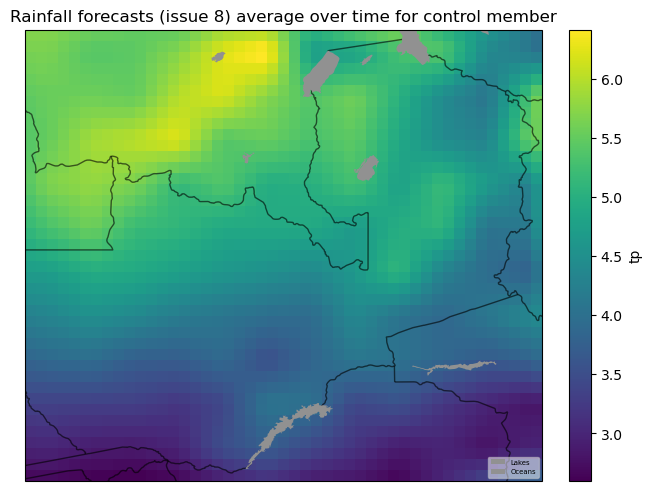

In [7]:
forecasts.isel(ensemble=0).mean("time").hip.viz.map(
    title=f"Rainfall forecasts (issue {issue}) average over time for control member"
)

Now that we got all the data we need, let's read the triggers file so we can merge the probabilities with it once we have them. This triggers file corresponds to the output of the `run-full-verification` notebook if we're in the first monitoring month. Then, we read the merged dataframe that already contains the probabilities from the previous months so we add the new probabilities to the existing merged dataframe.

**Note:**

This means that if you want to re-run the probabilities for the first monitoring month (e.g. May, June or July), you should delete or move the existing probabilities dataframes from the probs directory.

In [66]:
# Read triggers file
triggers_df = read_triggers(params)
triggers_df

,ready,set,index,district,category,issue_ready,lead_time,issue_set,FAR,FN,FP,FR,HR,RP,SR,TN,TP,prob,prob_ready,prob_set
0,0.29,0.29,SPI DJF,Chirundu,Moderate,8,12,9,0.444444,4,4,0.222222,0.556,5,0.777778,28,5,NaN,0.10,0.14
1,0.24,0.24,SPI DJF,Chirundu,Moderate,9,12,10,0.444444,4,4,0.222222,0.556,5,0.777778,28,5,NaN,0.14,NaN
2,0.24,0.19,SPI DJF,Gwembe,Moderate,8,12,9,0.444444,3,4,0.111111,0.625,5,0.888889,29,5,NaN,0.07,0.14
3,0.19,0.32,SPI DJF,Gwembe,Moderate,9,12,10,0.444444,3,4,0.000000,0.625,5,1.000000,29,5,NaN,0.14,NaN


### Run forecasts processing

Before calculating the accumulation, anomaly etc..., we need to obtain the accumulation periods we will be focusing on. These depend on the issue month of the forecasts that we are currently processing.

In [67]:
# Get accumulation periods (DJ, JF, FM, DJF, JFM...)
accumulation_periods = get_accumulation_periods(
    forecasts,
    params.start_season,
    params.end_season,
    params.min_index_period,
    params.max_index_period,
)
accumulation_periods

{'JFM': (1, 2, 3),
 'FMA': (2, 3, 4),
 'OND': (10, 11, 12),
 'NDJ': (11, 12, 1),
 'DJF': (12, 1, 2)}

Now we know which periods we will be computing the drought probabilities on. And this will be done in the next cell, by calling the `run_full_index_pipeline` function on each of them. That function derives the accumulation, the anomaly, performs the bias correction and obtains the probabilities.

In [68]:
# Compute probabilities for each accumulation period
probs_merged_dataframes = [
    run_full_index_pipeline(
        forecasts,
        observations,
        params,
        triggers_df,
        area,
        period_name,
        period_months,
    )
    for period_name, period_months in accumulation_periods.items()
]

INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed bias correction
INFO:root:Completed probabilities
INFO:root:Completed probabilities computation by district for the SPI JFM index
INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed bias correction
INFO:root:Completed probabilities
INFO:root:Completed probabilities computation by district for the SPI FMA index
INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed bias correction
INFO:root:Completed probabilities
INFO:root:Completed probabilities computation by district for the SPI OND index
INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed bias correction
INFO:root:Completed probabilities
INFO:root:Completed probabilities computation by district for the SPI NDJ index
INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed bias correction
INFO:root:Completed probabilities
INFO:root:Completed proba

We reorganise the dataframes and we are ready to save them.

In [69]:
probs_df, merged_df = zip(*probs_merged_dataframes)

probs_dashboard = pd.concat(probs_df).drop_duplicates()

merged_db = pd.concat(merged_df).sort_values(["prob_ready", "prob_set"])
merged_db = merged_db.drop_duplicates(
    merged_db.columns.difference(["prob_ready", "prob_set"]), keep="first"
)
merged_db = merged_db.sort_values(["district", "index", "category"])
merged_db

,ready,set,index,district,category,issue_ready,lead_time,issue_set,FAR,FN,FP,FR,HR,RP,SR,TN,TP,prob,prob_ready,prob_set
0,0.29,0.29,SPI DJF,Chirundu,Moderate,8,12,9,0.444444,4,4,0.222222,0.556,5,0.777778,28,5,NaN,0.10,0.14
1,0.24,0.24,SPI DJF,Chirundu,Moderate,9,12,10,0.444444,4,4,0.222222,0.556,5,0.777778,28,5,NaN,0.14,0.20
2,0.24,0.19,SPI DJF,Gwembe,Moderate,8,12,9,0.444444,3,4,0.111111,0.625,5,0.888889,29,5,NaN,0.07,0.14
3,0.19,0.32,SPI DJF,Gwembe,Moderate,9,12,10,0.444444,3,4,0.000000,0.625,5,1.000000,29,5,NaN,0.14,0.14


### Save drought probabilities

In [70]:
# Save all probabilities
probs_dashboard.to_csv(
    f"{params.data_path}/data/{params.iso}/probs/aa_probabilities_{params.index}_{params.issue}.csv",
    index=False,
)

In [71]:
# Save probabilities merged with triggers
merged_db.sort_values(["district", "index", "category"]).to_csv(
    f"{params.data_path}/data/{params.iso}/probs/aa_probabilities_triggers_pilots.csv",
    index=False,
)